# Tutorial 6: Stochastic Simulation of Constitutive Expression 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). This work was loosely influenced by a [similar tutorial](http://be150.caltech.edu/2016/handouts/gillespie_simulation.html) by [Justin Bois](http://bois.caltech.edu) and this document has inherited the associated licensing. 

--- 

In [161]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as snsi
sns.set()
sns.set_context('talk')
%matplotlib inline

In this tutorial, we will simulate expression from a constitutive expression using stochastics, known as a Gillespie simulation. 

## A Return to Constitutive Expression 

In [tutorial 5](t05_constitutive_expression.html), we examined the chemical master equation for constitutive expression and performed a numerical integration. We confirmed our numerical integration by computing the anlytical solution and found that at steady state, the mRNA distribution is Poisson. In all of this discussion, we have ignored the stochastic nature of gene expression. The mRNAs are produced from the random interactions between the polymerase and RNA polymerases, along with the myriad processes that involve transcription. Here, we will turn to stochastic simulations to simulate the time evolution of single cells over and over again and compare our result again to the analytical solution. 



In our discussion on constitutive expression, we stated that the production of an mRNA occurs at some rate $r$ and degradation of an mRNA occurs at a rate $\gamma$. We then determined the probability of observing $n$ mRNAs as a function of time by taking small steps in time $\Delta t$. By taking this finite step in time, we are dictating that both production *and* degradation occur in the same step, updating the probability. However, these steps are not alyways synchronous. Degradation and production are both Poisson processes, meaning that the time you have to wait until either process occurs is exponentially distributed. While one process may be more probable to occur than the other (say degradation relative to production when mRNA is greater than the steady state level), the time you have to wait until one of them occurs is exponentially distributed. 

Now, I say here they are exponentially distributed, but I don't say anything about the width of the distribution. To determine this scaling parameter, we can state mathematically that the probability a given event takes place in a time interval $\Delta t$ is 

$$
P( \lambda_i\, \vert\, \Delta t) = \lambda e^{-\lambda t}. \tag{1}
$$

where $\lambda$ is the **propensity** (i.e. how likely) of an even to occur. Here, I've used $P(a \vert b)$ to mean the probability that $a$ occurs **given** that $b$ has already occured. To determine the scale parameter, it's easier to think about the probabilty that the process takes longer than $\Delta t$ to occur, meaning it could occur anytime between $\Delta t$ and $\infty$. Mathematically, this is stated as

$$
P(t > \Delta t\, \vert\, \lambda_i) = \int\limits_{\Delta t}^\infty dt P(t \,\vert \lambda_i) = e^{-\lambda \Delta t}. \tag{2}
$$

What if we have n processes that arrive in different times, $\Delta t_1$,  $\Delta t_2$, \dots $\Delta t_n$? The probability that **neither** of them occur in our narrow window $\Delta t$ is given as

$$
P(\Delta t_1 > \Delta t\, \vert \lambda_1)P(\Delta t_2 > \Delta t\, \vert \lambda_2)\dots P(\Delta t_n > \Delta t \vert \lambda_n) = \prod\limits_i^n e^{-\lambda_i \Delta t} \tag{3},
$$

which follows directly from Eq. 2.  Remembering that products of exponetiated variables $x^2x^3$ is the same as the variable raised to the power of the summed exponents $x^5$, we can rewrite Eq. 3 to a more simplified form 

$$
\prod\limits_i^n e^{-\lambda_i\Delta t} = e^{-\sum\limits_i^n \lambda_i\Delta t}. \tag{4}
$$

The astute observe will notice taht this is the same as Eq. 3 with $\lambda = \sum\limits_i^n \lambda_i$. As the mean of an exponential distribution is $1 / \lambda$, we know that the amount of time we would have to wait until one process **did** occur is exponentially distrubed as 

$$
P(\Delta t \vert \mathbf{\lambda}) = e^{-\left(\sum\limits_i^n\lambda_i\right)^{-1}}. \tag{5}
$$

How can we use this to simulate our constitutive promoter? We know the rate of mRNA production $r$ and the rate of degradation $\gamma$. The number of mRNAs produced is independent of the number of mRNAs around while the number degraded **is** dependent this number. We can use these facts to say that the propensity for an mRNA to be produced is

$$
\lambda_\text{production} = r \tag{6}
$$

and the propensity for an mRNA to degrade is 

$$
\lambda_\text{degradation} = \gamma m \tag{7}.
$$

This means that for either of the processes to occur, the time you will have to wait is exponentially distributed as

$$
P(\Delta t\, \vert m) = e^{-\left(r + \gamma m\right)^{-1}}. \tag{8}
$$

## The Gillespie Algorithm 

The Gillespie algorithm uses this principle to simulate Poisson state changes. This algorithm can be increddibly helpful when even numerically integrating the master equation is cumbersome or computationally difficult. While it is relatively simple to implement, it can itself be computationally costly, often requiring long periods of simulation for convergence to the steady state value. 

The Gillespie algorithm as we will be using it today progresses as follows. 

1. Given the number of mRNAs, calculate the propensities of the state changes. Production will always simply be $r$, degradation will be $\gamma m$. 

2. Determine how long it would take for one of these two processes to occur by drawing a random number from an exponential distribution with a mean of $(r + \gamma m)^{-1}$.

3. Flip a coin to determine whenter an mRNA is produced or degraded. Rather than usinga  constant value for the probability of getting heads or tails, these will sale with the propensities of each state, For example the probability of producing an mRNA will only occur if the random  number we drew is less than $r / (r + \gamma m)$. 

4. Given the state of the flip, adjust the total number of mRNAs present and record the length of time it took for that to occur. 

This algorithm will then repeated many times for a preset number of steps, although not a pre determined length of time. 

Before we start to code the actual Gillespie simulation, let's define some parameters and instantiate the storage vectors. 

In [229]:
# Define parameters of the simulation. 
num_traj = 500 # The total number of trajectories. 
r = 10 # Production rate (1/min) of a strong promoter
gamma = 1 / 3 # Degradation rate (1/min) of mRNA.

With these parameters defined, we can write a function that will execute our Gillespie algorithm. As we will run this over and over again, it's worth writing this as a modular function.

In [230]:
def gillespie_mRNA(num_traj, prod_rate, deg_rate, m_0=0):
    """
    Performs a Gillespie simulation of mRNA production from 
    a constitutitive promoter given parameter values. 
    
    Parameters
    ----------
    num_traj : int
        The total number of trajectories to evaluate in the 
        simulation.
    prod_rate : float, 1/min
        The production rate of mRNA from the promoter
    deg_rate: float, 1/min
        The degradation rate of mRNA.
    m_0 : int or float
        The initial number of mRNAs.
        
    Returns
    -------
    m_t, dt, time : arrays of length num_traj
        Vectors of the total number of mRNAs at each step,
        the dwell time for each step to occur, and the 
        total time of the simulation. 
    """
    # Instantiate the storage vectors. 
    m_t = np.zeros(num_traj)
    dt = np.zeros(num_traj)
    time = np.zeros(num_traj)
    
    # Set the initial condition. 
    m_t[0] = m_0
    
    # Loop through each trajectory and perform the simulation. 
    for i in range(1, num_traj):
        
        # Calculate the propensity for each reaction. 
        lam_prod = prod_rate
        lam_deg = m_t[i-1] * deg_rate
        
        # Sum the propensities and calculate the dwell time. 
        sum_prop = lam_prod + lam_deg
        dwell_time = np.random.exponential(1 / sum_prop)
        dt[i] = dwell_time
        
        # Update the current time. 
        time[i] = time[i-1] + dwell_time
        
        
        # Flip a coin and determine what to do
        flip = np.random.rand()
        if flip < (lam_prod /sum_prop):
            # Make an mRNA
            m_t[i] = m_t[i-1] + 1
        else:
            #Degrade an mRNA
            m_t[i] = m_t[i-1] - 1
        # And that's it folks!
    return [m_t, dt, time]

This function will return all three storage vectors as a single list. Using the parameters we've already defined, let's run it!

Text(0, 0.5, 'number of mRNA')

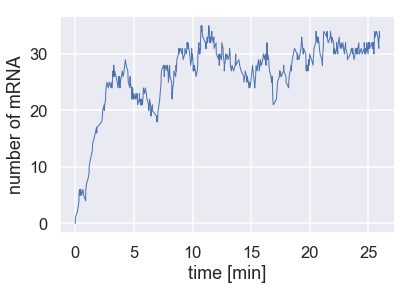

In [231]:
# Run the Gillespie simulation. 
m_t, dt, time = gillespie_mRNA(num_traj, r, gamma, m_0=0)

# Plot the number of mRNAs as a function of time. 
plt.plot(time, m_t, '-', linewidth=1)
plt.xlabel('time [min]')
plt.ylabel('number of mRNA')

Each time we run this simulation, it should be totally different! In some cases, it won't hover around teh stedy state value and may seem to wander in to the netherlands of mRNA copy number. The real utility of Gillespie simulations comes to running them a huge number of times. Let's run this same Gillespie simulation 1000 times and plot all of the trajectories. 

In [232]:
# Define the number of simulations to be performed. 
num_sim = 1000

# Set up storage vectors for the entire run. 
m_t = np.zeros((num_sim, num_traj))
dt = np.zeros((num_sim, num_traj))
time = np.zeros((num_sim, num_traj))

# Loop through each simulation. 
for i in range(n_sim):
    # Run the Gillespie
    sim_m_t, sim_dt, sim_time = gillespie_mRNA(num_traj, r, gamma)
    
    # Add the results to our storage matrices. 
    m_t[i, :] = sim_m_t
    dt[i, :]= sim_dt
    time[i, :]= sim_time

Text(0, 0.5, 'number of mRNA')

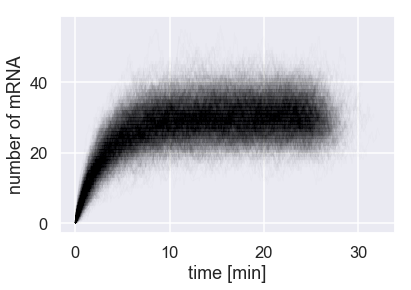

In [235]:
# Now plot each simulation as a thin black line. 
for i in range(num_sim):
    plt.plot(time[i, :], m_t[i, :], color='black', alpha=0.01, lw=1)
    
# Add labels and display. 
plt.xlabel('time [min]')
plt.ylabel('number of mRNA')

We see now that even though each individual trajectory may differ from the steady state value, the distribution of mRNA copy number is centered around this value. We can show this by plotting the mean copy number at each time point over the individual traces. 

To calculate this mean, we can't simply take the mean across every entry in our array as each number has a different time point. To compute the mean, we have to weight each count by the length of time that it existed, divided by the total time of that particular window. 

As seeing is believing, below we compute the mean mRNA number as a function of time. 


Text(0, 0.5, 'number of mRNAs')

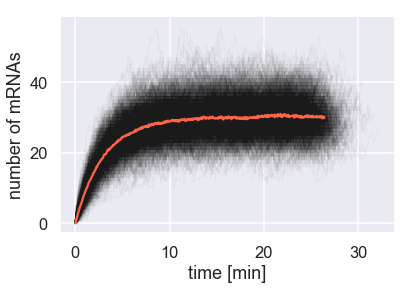

In [250]:
# Make empty storage vectors for the mean mRNA and time.
mean_m = np.zeros(num_traj) 
mean_time = np.zeros(num_traj)

# Loop through each entry in the matrix 
for i in range(1, num_traj): 
    
    # Compute the mean
    mean_m[i] = np.sum(m_t[:, i] * dt[:, i]) / np.sum(dt[:, i])
    
    # Compute the mean lapse in time. 
    mean_time[i] = np.mean(time[:, i])
    
# Now plot everything together. 
for i in range(num_sim):
    plt.plot(time[i, :], m_t[i, :],'k-', lw=1, alpha=0.03)
    
# Plot the mean. 
plt.plot(mean_time, mean_m, '-', color='tomato')
plt.xlabel('time [min]')
plt.ylabel('number of mRNAs')

The mean converges to about 30 mRNA per cell, which is what is predicted by our model for the steady state solution.  

## Examining the Distribution

In [217]:
# Plot the distribution 
max_mRNA = int(np.max(m_t)) +  1

p_m = np.zeros(max_mRNA)

# Make a vector to store the counts. 
for i in range(n_sim):
    for j in range(n_traj):
        p_m[int(m_t[i, j])] += dt_vec[i, j]
        
# normalize it. 
p_m = p_m / np.sum(p_m)

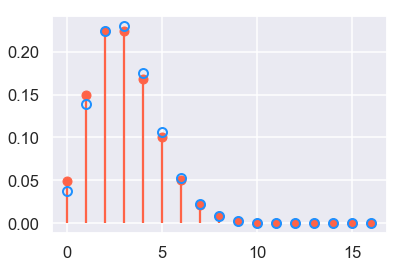

In [218]:
# Plot the poisson. 
poisson = scipy.stats.poisson.pmf(np.arange(0, max_mRNA), r / gamma)
plt.plot(np.arange(max_mRNA), poisson,'o', color='tomato')
plt.vlines(np.arange(max_mRNA), 0, poisson, color='tomato')# plot the distribution. 
plt.plot(np.arange(max_mRNA), p_m, 'o', markeredgecolor='dodgerblue', 
        markerfacecolor='none', markeredgewidth=2)

In [249]:
mean_m

array([0.        , 1.        , 1.96744183, ..., 0.        , 0.        ,
       0.        ])